In [8]:
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import itertools
from statsmodels.tsa.stattools import adfuller
sns.set_theme(style='darkgrid')

In [9]:
pd.set_option("display.max_columns", None)

In [10]:
from data import get_data
from helpers import pred_to_perf

In [11]:
data = pd.read_excel('data/data.xlsx', index_col=0, skiprows=[0, 1, 2, 3, 4, 5, 6, 8])
data.head()
# data.to_csv('data/data.csv')

,SPI,SMALL,MID,LARGE,SMALL DIV ES,SMALL ROE ES,SMALL SALES ES,SMALL EPS ES,SMALL DEBT ES,LARGE DIV ES,LARGE ROE ES,LARGE SALES ES,LARGE EPS ES,LARGE DEBT ES,MATERIALS EU,CONSUMER STAPLE EU,INDUSTRIALS EU,CONSUMER DIS. EU,HEALTH CARE EU,FINANCIALS EU,VSMI,VSTOXX
2006-01-04,5851.15,8756.96,6038.74,5833.18,133.48,11.72,18082.24,550.58,3153.603,109.08,19.84,3056.12,390.69,149.2413,178.64,112.61,141.34,90.73,113.33,112.92,13.04,13.9452
2006-01-05,5837.78,8771.81,6029.12,5818.60,133.48,11.72,18079.05,549.08,3151.462,109.05,19.82,3052.53,389.71,149.2018,176.64,111.82,140.49,90.35,113.58,112.54,13.22,14.1421
2006-01-06,5850.81,8802.67,6061.71,5828.32,133.46,11.72,18118.46,549.57,3168.757,109.14,19.83,3048.58,388.93,148.4073,177.97,112.21,141.26,90.89,113.72,113.26,13.10,13.7315
2006-01-09,5849.79,8803.52,6085.14,5823.36,133.50,11.72,18111.93,549.30,2855.768,109.37,19.84,3022.46,389.30,125.9870,178.12,112.13,141.31,91.39,113.75,113.49,13.53,14.3612
2006-01-10,5811.98,8804.61,6043.21,5785.15,133.50,11.72,18027.36,548.71,2853.394,109.27,19.86,3019.92,390.59,122.4944,175.83,112.20,140.68,90.89,112.71,112.51,14.18,14.5109


bench_price, target_prices, features = get_data()
daily_returns = target_prices.pct_change()

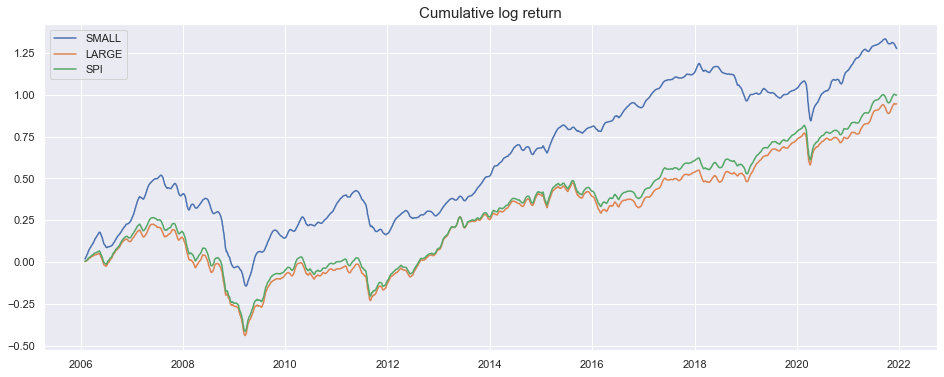

In [12]:
fig, ax = plt.subplots(figsize=(16,6))
data_plot = np.log((pd.concat([target_prices, bench_price.rename('SPI')], axis=1).pct_change() + 1).cumprod().rolling(20).mean())
sns.lineplot(data=data_plot, dashes=False)
plt.title('Cumulative log return', fontsize=15)
plt.show()

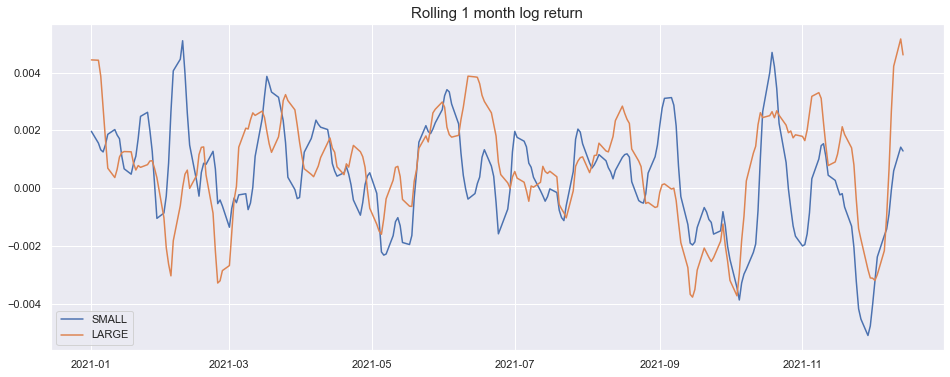

In [13]:
fig, ax = plt.subplots(figsize=(16,6))
data_plot = target_prices.rolling(5).apply(lambda x: np.log(x[-1] / x[0])/ len(x)).rolling(5).mean()
sns.lineplot(data=data_plot.loc['2021-01-01':], dashes=False)
plt.title('Rolling 1 month log return', fontsize=15)
plt.show()

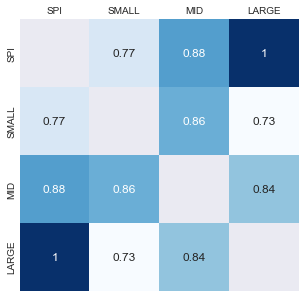

In [14]:
corr = data[data.columns[:4]].pct_change().resample('W').mean().corr().round(4)

fig, ax = plt.subplots(figsize=(5,5))
mask = np.identity(len(corr))
sns.heatmap(data=corr, annot=True, cmap='Blues', cbar=False, mask=mask, annot_kws=dict(size=12))
ax.tick_params(axis='both', which='major', labelsize=10, labelbottom=False, labeltop=True, length=0)
plt.show()

In [15]:
data_stats = data[data.columns[:4]]
data_annual_ret = data_stats.pct_change().mean() * 252 * 100
data_annual_std = data_stats.pct_change().std() * np.sqrt(252) * 100
data_annual_sharpe = data_annual_ret.div(data_annual_std)
data_stats = pd.concat([data_annual_ret, data_annual_std, data_annual_sharpe], axis=1)
data_stats.columns = ['Annualized average return', 'Annualized Std', 'Sharpe Ratio']
data_stats.round(2)

,Annualized average return,Annualized Std,Sharpe Ratio
SPI,7.50,16.50,0.45
SMALL,8.19,10.20,0.80
MID,9.47,15.82,0.60
LARGE,7.31,17.17,0.43


In [24]:
returns = target_prices.pct_change().shift(1).resample('W-FRI').agg(lambda x: (x + 1).prod() - 1)
best_pred = returns.rank(axis=1).replace({1: 0., 2: 1.}).shift(-1)

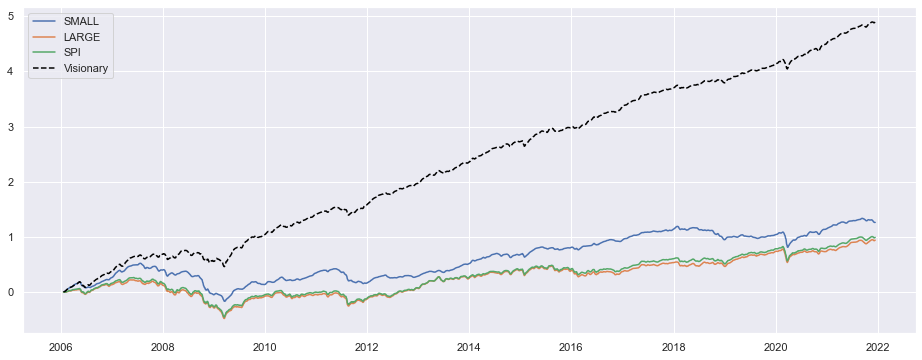

In [27]:
fig, ax = plt.subplots(figsize=(16,6))
best_perf = np.log(pred_to_perf(best_pred, daily_returns=daily_returns).rolling(10).mean())
data_plot = np.log((pd.concat([target_prices, bench_price.rename('SPI')], axis=1).pct_change() + 1).reindex(best_perf.index).cumprod().rolling(10).mean())
sns.lineplot(data=data_plot, dashes=False)
sns.lineplot(data=best_perf, color='black', linestyle='--', label='Visionary')
plt.legend()
plt.show()

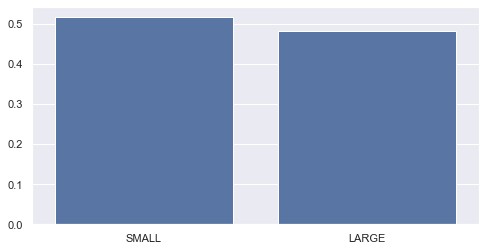

In [28]:
L = len(best_pred)
df_results = (best_pred.sum(axis=0) / L).rename('Best_prediction')
df_results = df_results.reset_index()
df_results = df_results.melt(id_vars='index', var_name='strategie', value_name='frequence')

fig, ax = plt.subplots(figsize=(8,4))
sns.barplot(data=df_results, x='index', y='frequence', hue='strategie')
ax.get_legend().remove()
ax.set_xlabel(None)
ax.set_ylabel(None)
plt.show()

features_weekly_returns = features.pct_change().resample('W').mean()
target_weekly_returns = target_prices.pct_change().resample('W').mean()

In [29]:
features_weekly_returns = features.resample('W').apply(lambda x: np.log(x[-1] / x[0]) / len(x))
target_weekly_returns = target_prices.resample('W').apply(lambda x: np.log(x[-1] / x[0]) / len(x))

<ipython-input-29-b92753e8f3b4>:1: RuntimeWarning: invalid value encountered in log
  features_weekly_returns = features.resample('W').apply(lambda x: np.log(x[-1] / x[0]) / len(x))


In [33]:
df_features_corr = pd.DataFrame(index=target_weekly_returns.columns)
for col in features_weekly_returns:
    df_features_corr[col] = target_weekly_returns.shift(-1).corrwith(features_weekly_returns[col])
df_features_corr.round(4) * 100

,SMALL,MID,LARGE,SMALL DIV ES,SMALL ROE ES,SMALL SALES ES,SMALL EPS ES,SMALL DEBT ES,LARGE DIV ES,LARGE ROE ES,LARGE SALES ES,LARGE EPS ES,LARGE DEBT ES,MATERIALS EU,CONSUMER STAPLE EU,INDUSTRIALS EU,CONSUMER DIS. EU,HEALTH CARE EU,FINANCIALS EU,VSMI,VSTOXX
SMALL,11.38,11.43,4.94,3.76,5.15,-2.16,4.70,-3.49,5.80,-0.14,6.76,7.04,1.56,9.89,3.04,9.5,9.94,0.35,4.75,0.05,1.62
LARGE,-14.06,-9.88,-13.06,-0.51,3.50,1.18,8.19,0.12,7.38,2.05,8.01,11.12,-3.44,-9.65,-14.04,-9.3,-8.38,-12.22,-10.69,8.92,11.14


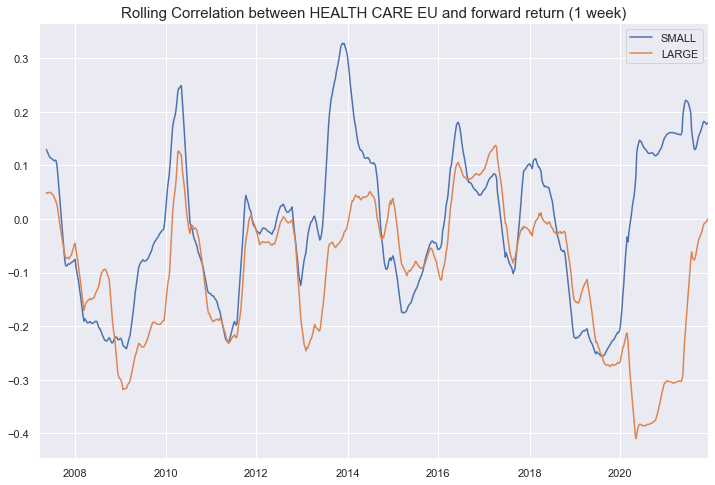

In [34]:
fig, ax = plt.subplots(figsize=(12, 8))
feature = 'HEALTH CARE EU'
target_weekly_returns.shift(-1).rolling(63).corr(features_weekly_returns[feature]).dropna().rolling(10).mean().plot(ax=ax)
plt.title(f'Rolling Correlation between {feature} and forward return (1 week)', fontsize=15)
plt.show()

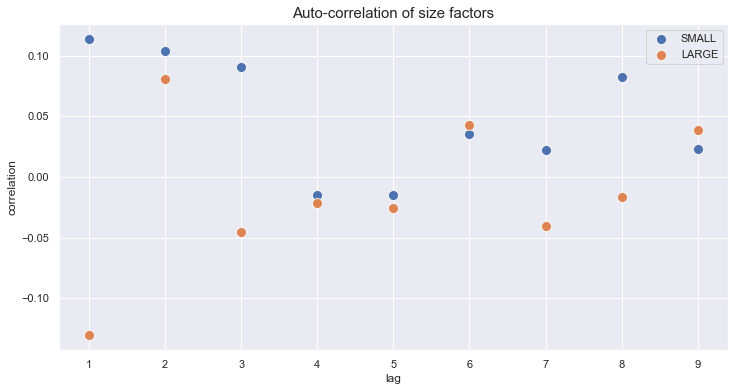

In [35]:
week_input_period = 10
auto_corr = {}
fig, ax = plt.subplots(figsize=(12, 6))
for size in target_weekly_returns.columns:
    auto_corr[size] = []
    for l in range(1, week_input_period):
        auto_corr[size].append(target_weekly_returns[size].corr(target_weekly_returns[size].shift(-l)))
    sns.scatterplot(x=range(1, week_input_period), y=auto_corr[size], label=size, s=100)
plt.xticks(range(1, week_input_period))
plt.title('Auto-correlation of size factors', fontsize=15)
plt.xlabel('lag')
plt.ylabel('correlation')
plt.show()

In [16]:
def fast_fracdiff(x, d):
    import pylab as pl
    T = len(x)
    np2 = int(2 ** np.ceil(np.log2(2 * T - 1)))
    k = np.arange(1, T)
    b = (1,) + tuple(np.cumprod((k - d - 1) / k))
    z = (0,) * (np2 - T)
    z1 = b + z
    z2 = tuple(x) + z
    dx = pl.ifft(pl.fft(z1) * pl.fft(z2))
    return np.real(dx[0:T])

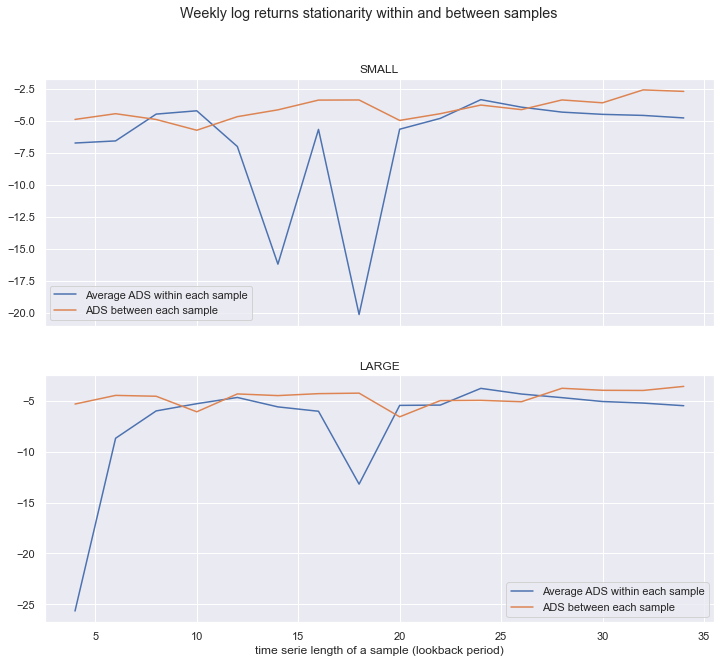

In [46]:
df_ads = pd.DataFrame(index=['ADS within each sample', 'ADS between each sample'])
log_weekly_returns = target_prices.resample('W-FRI').apply(lambda x: np.log(x[-1] / x[0]) / len(x))

if len(d_list) != len(log_weekly_returns.columns):
    print('erreur')
    
input_period = 8

ads_input = {}
ads_mean_input = {}
input_periods = range(4, 36, 2)

for feature in log_weekly_returns:
    feature_fdf = log_weekly_returns[feature].loc['2010-01-01':]
    feature_fdf_normalized = (feature_fdf - feature_fdf.mean()) / feature_fdf.std()
    
    ads_input[feature] = []
    ads_mean_input[feature] = []
    for input_period in input_periods:
        ads_input[feature].append(feature_fdf_normalized.rolling(input_period).apply(lambda x: adfuller(x)[0]).mean())
        ads_mean_input[feature].append(adfuller(feature_fdf_normalized.rolling(input_period).mean().dropna())[0])

fig, axs = plt.subplots(2, 1, figsize=(12, 10), sharex=True)

for i, feature in enumerate(log_weekly_returns):
    sns.lineplot(ax=axs[i], x=input_periods, y=ads_input[feature], label='Average ADS within each sample', dashes=False)
    sns.lineplot(ax=axs[i], x=input_periods, y=ads_mean_input[feature], label='ADS between each sample', dashes=False)
    axs[i].set_title(feature)
plt.xlabel('time serie length of a sample (lookback period)')
plt.suptitle('Weekly log returns stationarity within and between samples')
plt.show()

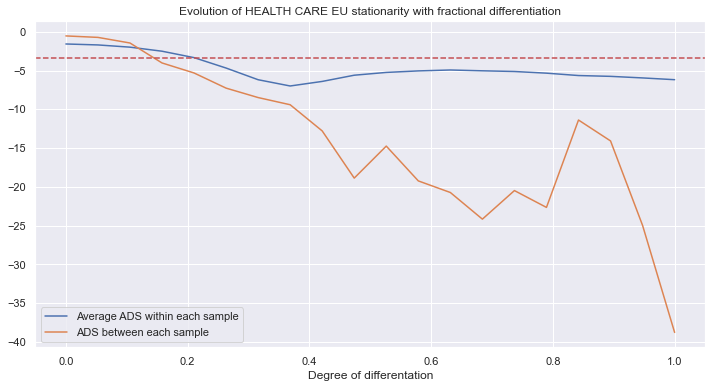

In [51]:
feature = 'HEALTH CARE EU'
feature_fdf = data[feature].loc['2010-01-01':]

ads_input = []
ads_mean_input = []
d_list = np.linspace(0, 1, 20)

for d in d_list:
    feature_fdf = pd.Series(fast_fracdiff(feature_fdf, d))[50:]
    ads_input.append(feature_fdf.rolling(input_period).apply(lambda x: adfuller(x)[0]).mean())
    ads_mean_input.append(adfuller(feature_fdf.rolling(input_period).mean().dropna())[0])

fig, ax = plt.subplots(figsize=(12, 6))
plt.plot(d_list, ads_input, label='Average ADS within each sample')
plt.plot(d_list, ads_mean_input, label='ADS between each sample')
plt.title(f'Evolution of {feature} stationarity with fractional differentiation')
plt.axhline(y=-3.43, color='r', linestyle='--')
plt.xlabel('Degree of differentation')
plt.legend()
plt.show()

In [50]:
df_ads = pd.DataFrame(index=['ADS within each sample', 'ADS between each sample'])

d_list = [0.4, 0.4, 0.4, 0.4, 0., 0.2, 0.2, 0.2, 0.2, 0.4, 0.2, 0.2, 0.2, 0., 0.1, 0.3, 0.3, 0.3, 0.4, 0.3, 0., 0.1]

if len(d_list) != len(data.columns):
    print('erreur')
    
for feature, d in zip(data.columns, d_list):
    feature_fdf = data[feature].loc['2010-01-01':]
    feature_fdf = pd.Series(fast_fracdiff(feature_fdf, d))[50:]
    feature_fdf_normalized = (feature_fdf - feature_fdf.mean()) / feature_fdf.std()
    input_period = 42

    ads_input = feature_fdf_normalized.rolling(input_period).apply(lambda x: adfuller(x)[0])
    ads_mean_input = adfuller(feature_fdf_normalized.rolling(input_period).mean().dropna())[0]
    df_ads[feature] = np.array([ads_input.mean(), ads_mean_input])
    
display(df_ads.round(2))

,SPI,SMALL,MID,LARGE,SMALL DIV ES,SMALL ROE ES,SMALL SALES ES,SMALL EPS ES,SMALL DEBT ES,LARGE DIV ES,LARGE ROE ES,LARGE SALES ES,LARGE EPS ES,LARGE DEBT ES,MATERIALS EU,CONSUMER STAPLE EU,INDUSTRIALS EU,CONSUMER DIS. EU,HEALTH CARE EU,FINANCIALS EU,VSMI,VSTOXX
ADS within each sample,3.50,3.50,3.50,3.50,3.50,3.50,3.50,3.50,3.50,3.50,3.50,3.50,3.50,3.50,3.50,3.50,3.50,3.50,3.5,3.50,3.50,3.50
ADS between each sample,-3.09,-3.22,-3.09,-3.11,-5.58,-3.67,-4.94,-4.76,-3.47,-6.44,-5.58,-5.14,-2.88,-5.34,-3.25,-5.38,-3.78,-3.85,-4.7,-3.59,-5.05,-4.95


In [4]:
bench_price, target_prices, features, features_stationary = get_data()

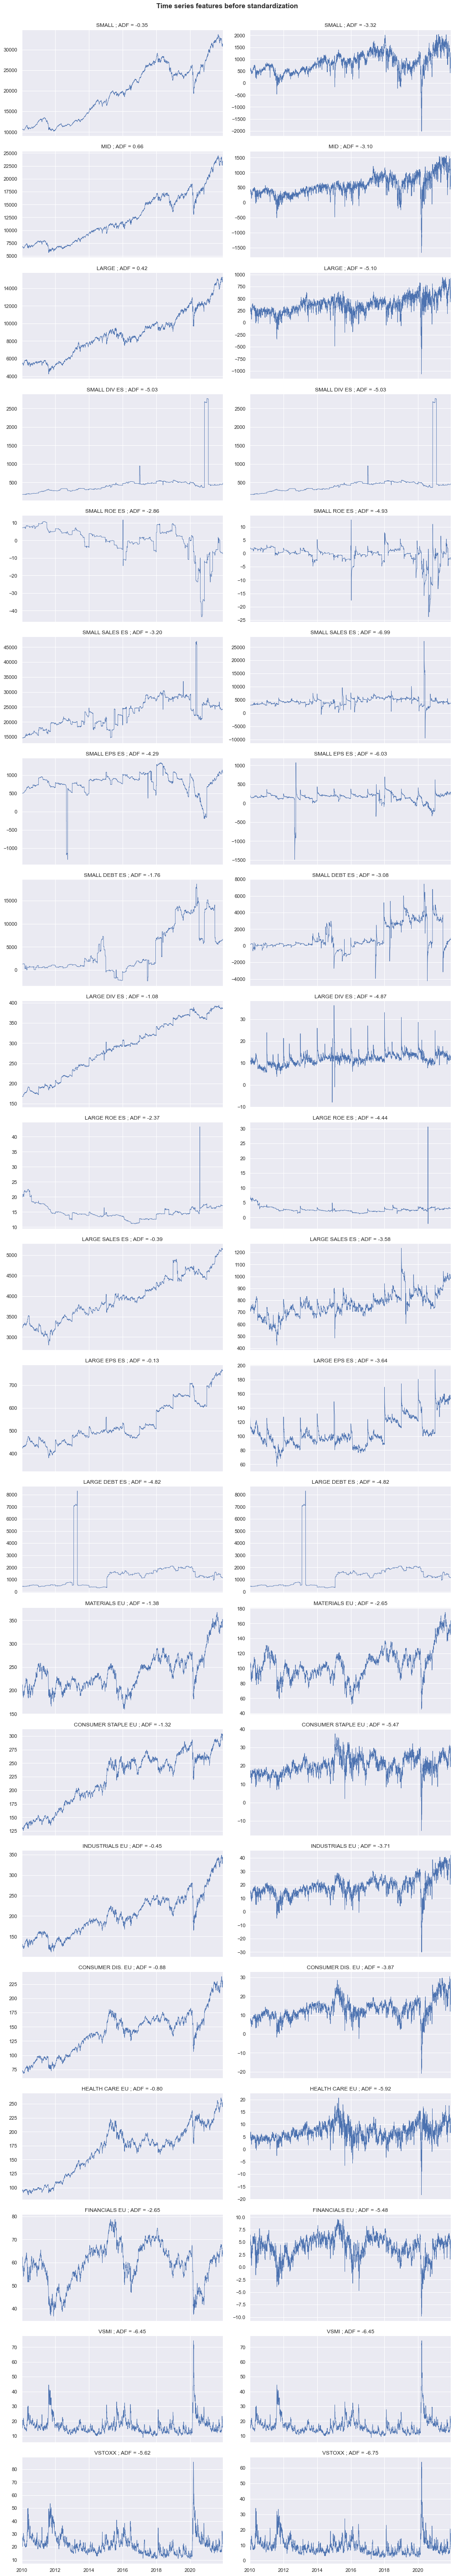

In [49]:
data_plot = features.loc['2010-01-01':]
data_plot_stat = features_stationary.loc['2010-01-01':]

number_feature = len(data_plot.columns)
fig, axs = plt.subplots(number_feature, 2, figsize=(14, 80), sharex=True)

for i, col in enumerate(data_plot.columns):
    
    ads = adfuller(data_plot[col].values)[0]
    data_plot[col].plot(ax=axs[i, 0], lw=0.8)
    axs[i, 0].set_title(col + f' ; ADF = {ads:.2f}')
    
    ads_stat = adfuller(data_plot_stat[col].values)[0]
    data_plot_stat[col].plot(ax=axs[i, 1], lw=0.8)
    axs[i, 1].set_title(col + f' ; ADF = {ads_stat:.2f}')
    
plt.suptitle('Time series features before standardization', fontsize=15, fontweight='bold')
fig.tight_layout()
fig.subplots_adjust(top=0.97)
plt.show()

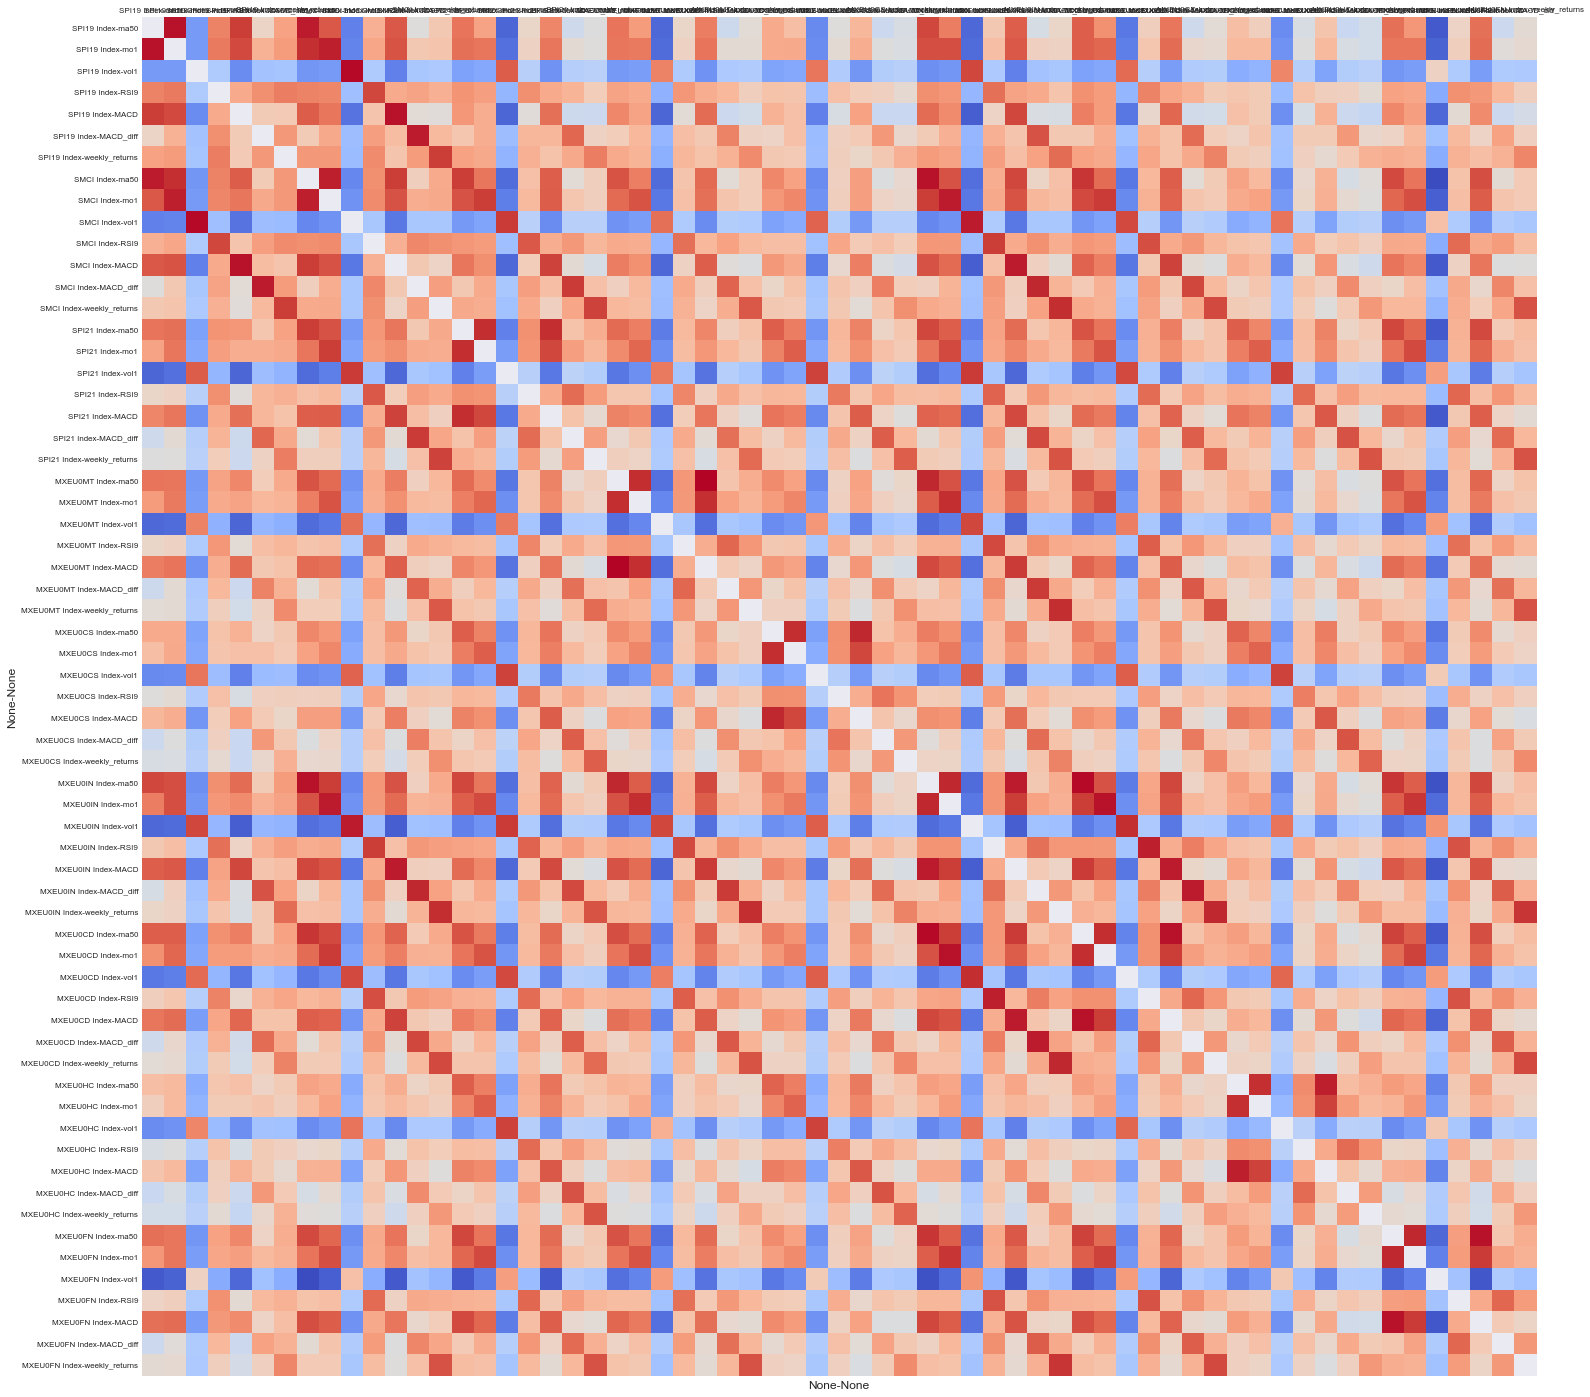

In [53]:
corr = data_plot.corr().round(2)

fig, ax = plt.subplots(figsize=(25,25))
mask = np.identity(len(corr))
sns.heatmap(data=corr, annot=False, cmap='coolwarm', cbar=False, mask=mask, annot_kws=dict(size=12))
ax.tick_params(axis='both', which='major', labelsize=8, labelbottom=False, labeltop=True, length=0)
plt.show()